In [19]:
from math import sqrt
from datetime import datetime

import pandas as pd
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]


In [6]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

### Exploratory data analysis

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1383 entries, 2014-01-07 to 2017-10-20
Data columns (total 7 columns):
Open                 1383 non-null float64
High                 1383 non-null float64
Low                  1383 non-null float64
Close                1383 non-null float64
Volume (BTC)         1383 non-null float64
Volume (Currency)    1383 non-null float64
Weighted Price       1383 non-null float64
dtypes: float64(7)
memory usage: 86.4 KB


In [10]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [17]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)',
       'Weighted Price'],
      dtype='object')

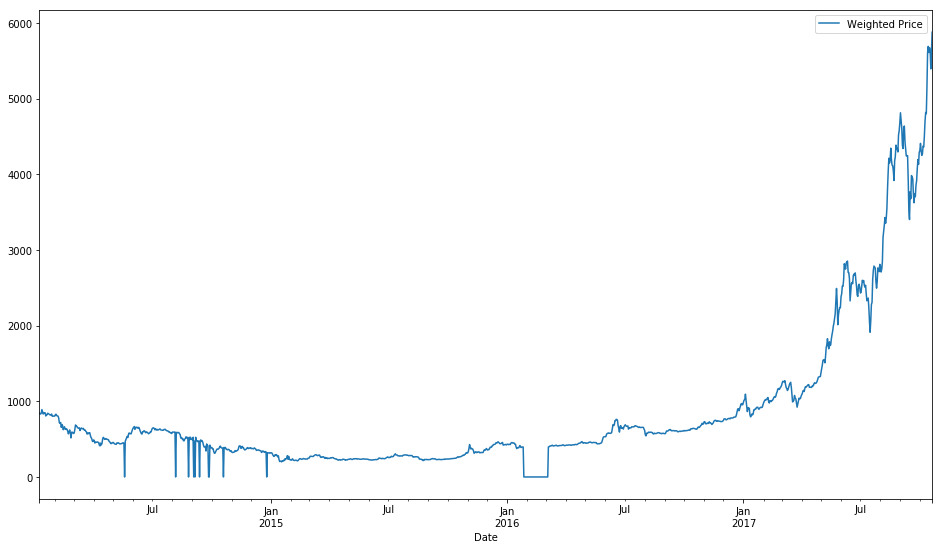

In [20]:
data.plot(y='Weighted Price')

In [21]:
# fill missing values 
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

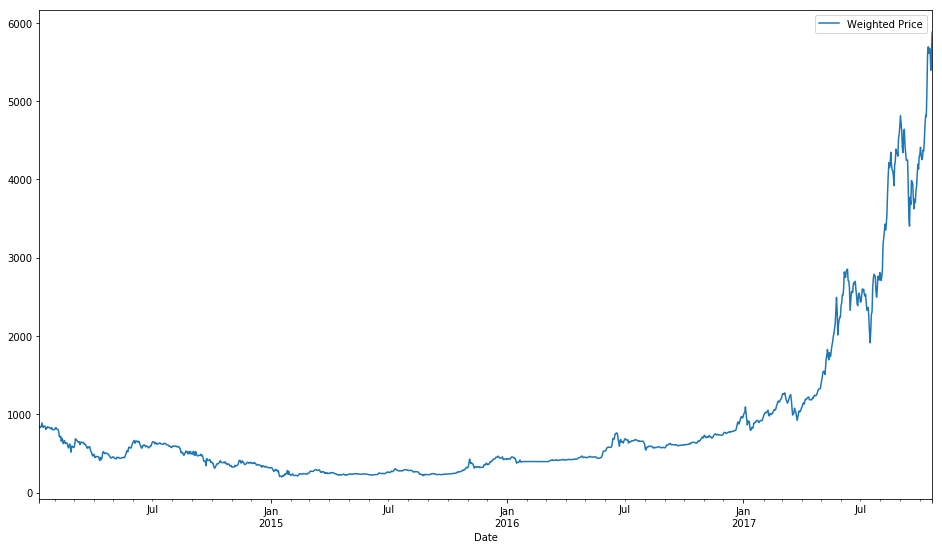

In [22]:
data.plot(y='Weighted Price')

### Data preprocessing

In [23]:
# Use MinMaxScaler to normalize Weighted Price to range from 0 to 1

values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [24]:
# Split 70% of data for training and 30% for testing

train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

968 415


In [27]:
# Create function for creating dataset with look back

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [28]:
# Generate dataset for trainX, trainY, testX, testY

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [29]:
# Reshape X for model training

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [30]:
# Train model with 40 epochs

model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=40, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

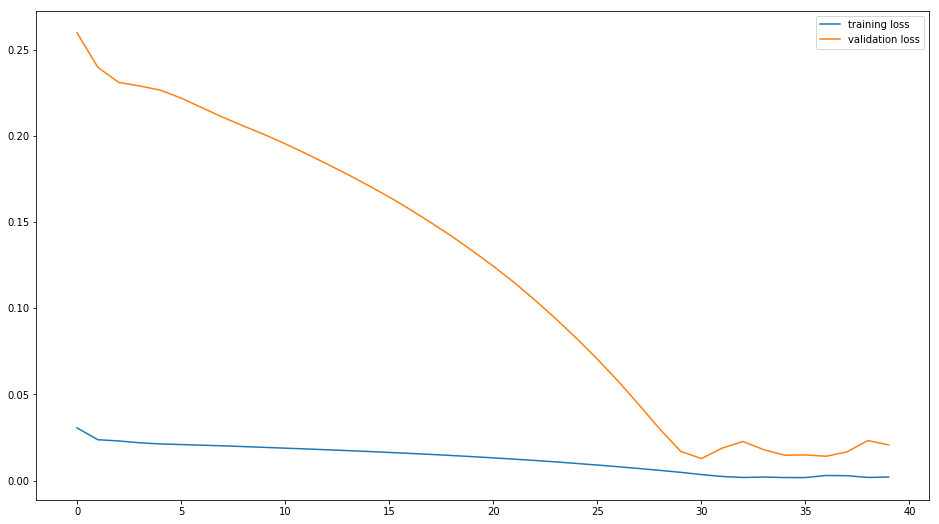

In [46]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

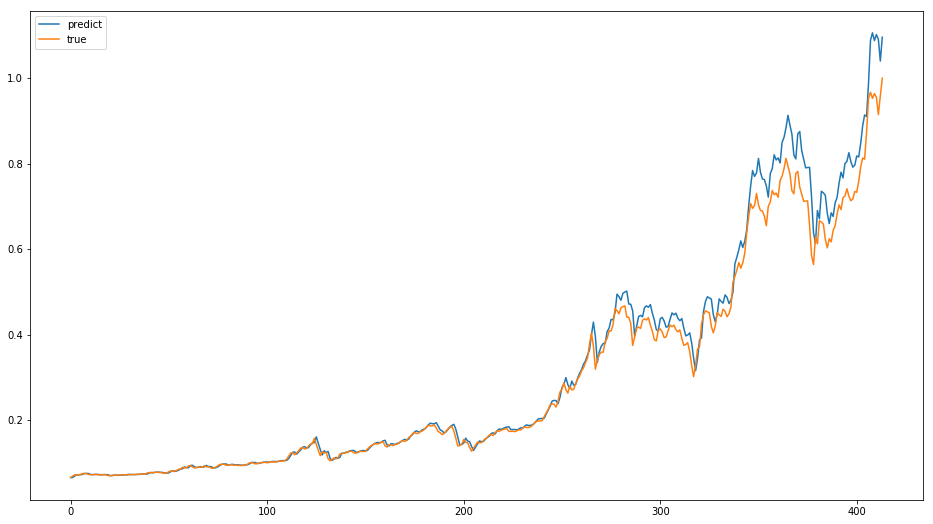

In [48]:
# Make prediction using textX and plotting line graph against testY

yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()

In [49]:
# Scale data back to normal value
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [50]:
# RMSE

rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

# if we train for a few more epochs we can probably lower the RMSE

Test RMSE: 217.376


In [57]:
# get dates for x-axis
predictDates = data.tail(len(testX)).index

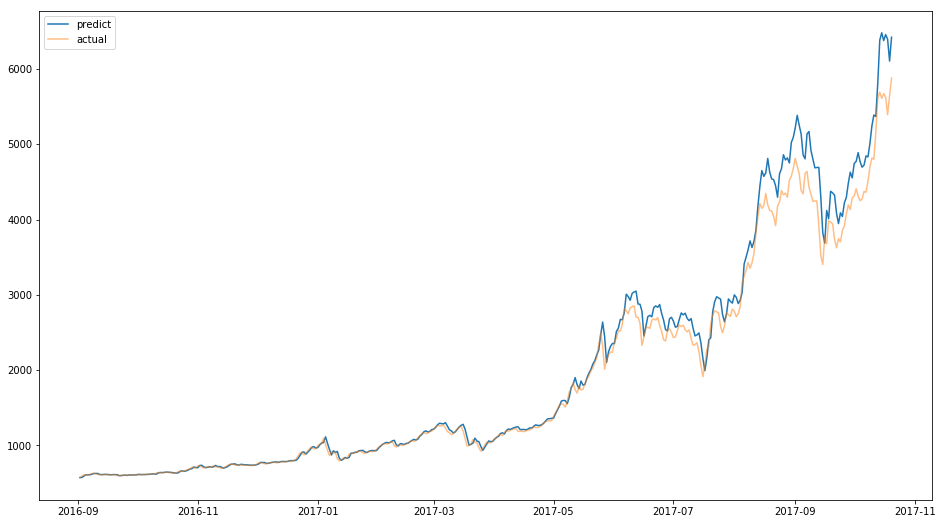

In [60]:
plt.plot(predictDates, yhat_inverse, label='predict')
plt.plot(predictDates, testY_inverse, label='actual', alpha=0.5)
plt.legend()